In [1]:
#Should take ~30 min to run
import sys

sys.path.insert(0, '../../PSC')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import pandas as pd
from tqdm import tqdm

from pymanopt.manifolds.stiefel import Stiefel

from PSC.utils import dist_Gr, dist_St
from PSC.projections import manopt_alpha, PCA, pi_alpha_all, yhat_alpha_all

# Construct Covers and Partitions of Unity on $S^1, S^1\times S^1$

## Partitions of unity on $S^1$

Cover the circle with $N$ intervals $U_i = \left(\frac{i}{N}, \frac{i+2}{N}\right), i=0,\dots,N-1$ where values are taken mod 1.

For $x\in[0,1]$, we find the $U_i$ with largest $i$ containing it. By construction it will also lie in either $U_{i-1}$ or $U_{i+1}$ where subscripts are read mod $N$.

First we make a vectorized version of the bump function. Input arrays of lower/upper bounds, both shape `(bounds,)` and any array of points `(num_points,)`. Output should be of shape `(num_points, bounds)`. $i,j$th entry is the value of the bump function supported on `lower_bound[i], upper_bound[i]` evaluated at `point[j]`.

In [3]:
def psi_on_line(lower_bounds, upper_bounds, points): #Values of bump functions supported on arrays lower_bounds, upper_bounds, evaluated on array points
    out = np.zeros((max(points.shape),max(lower_bounds.shape)))
    mask = (points[:, None] >= lower_bounds) & (points[:, None] <= upper_bounds) #When points outside interval, keep zero
    out[mask]=np.cos(np.pi*( #Otherwise, evaluate bump function at those points
            np.repeat(points,mask.sum(axis=1)) #Equivalent of (np.cos(np.pi*(point-(lower+upper)/2)/(upper-lower)))**2, broadcasted appropriately
            -(np.broadcast_to(upper_bounds, mask.shape)[mask]
              +np.broadcast_to(lower_bounds, mask.shape)[mask])/2)/(np.broadcast_to(upper_bounds, mask.shape)[mask]-np.broadcast_to(lower_bounds, mask.shape)[mask]))**2
    return out

In [4]:
def psi_on_circle(lower_bounds, upper_bounds, points): #Handles the case when the lower_bounds, upper_bounds are circle-valued
    output = np.zeros((max(points.shape), max(lower_bounds.shape)))

    circle_ints = (lower_bounds >= upper_bounds)
    circle_lower_bounds = lower_bounds[circle_ints]
    circle_upper_bounds = upper_bounds[circle_ints]
    circle_ints_output_mask = np.broadcast_to(circle_ints.reshape(1,len(upper_bounds)), output.shape) #apply to output

    upper_boundary_cond = points > 0.5 #Distinguishes whether it will need +1 when evaluated on a circle int, or not
    upper_boundary_points = points[upper_boundary_cond]
    upper_boundary_output_mask = np.broadcast_to(upper_boundary_cond.reshape(len(points),1), output.shape) #apply to output, only shows upper boundary pts

    #Only show nonzero line ints
    line_ints = (lower_bounds <= upper_bounds)
    line_ints_output_mask = np.broadcast_to(line_ints.reshape(1,len(upper_bounds)),output.shape)

    #Only show circle ints
    circle_ints = (lower_bounds >= upper_bounds)
    circle_ints_output_mask = np.broadcast_to(circle_ints.reshape(1, len(upper_bounds)), output.shape)

    def shift_bound_psi(c_lower_bounds, c_upper_bounds, c_points):
      return psi_on_line(c_lower_bounds, c_upper_bounds+1, c_points).ravel()

    def shift_bound_point_psi(c_lower_bounds, c_upper_bounds, c_points):
      return psi_on_line(c_lower_bounds, c_upper_bounds+1, c_points+1).ravel()

    output[line_ints_output_mask] = psi_on_line(lower_bounds[line_ints], upper_bounds[line_ints], points).ravel()

    output[circle_ints_output_mask & upper_boundary_output_mask] = shift_bound_psi(circle_lower_bounds, circle_upper_bounds, points[upper_boundary_cond])

    output[circle_ints_output_mask & ~upper_boundary_output_mask] = shift_bound_point_psi(circle_lower_bounds, circle_upper_bounds, points[~upper_boundary_cond])

    return output

## Partitions of Unity on $S^1\times S^1$

Given $(x_1, x_2)$ on $T^2$:
* Evaluate first coord $x_1$ on all $\phi_i: S^1\to \mathbb{R}$
* Evaluate second coord $x_2$ on all $\phi_i: S^1\to \mathbb{R}$
* Outer product is matrix giving values of $\phi_i(x_1)\cdot \phi_j(x_2)$ for every pair of $S^1$ partition of unity functions

In [5]:
def psi_on_t2(s1_open_sets, points):
  num_points = points.shape[0]
  num_s1_open_sets = s1_open_sets.shape[0]

  #Separate s1_open_sets into upper and lower bounds
  lower_bounds = s1_open_sets[:,0]
  upper_bounds = s1_open_sets[:,1]

  #Separate points into first and second coordinates
  x1s = points[:,0]
  x2s = points[:,1]

  #First two coords are psi_circle outputs, (num_points, num_open_sets)
  psi_x1_values = psi_on_circle(lower_bounds, upper_bounds, x1s)
  psi_x2_values = psi_on_circle(lower_bounds, upper_bounds, x2s)

  #outer product along num_points axis, with shape (num_points, num_s1_open_sets, num_s1_open_sets)
  outer_prod = np.einsum('ij,ik->ijk',psi_x1_values, psi_x2_values)

  #Return outer product normalized by sum of function values at point
  sums = np.sum(outer_prod, axis=(1,2)).reshape(num_points, 1)
  return np.einsum('ijk,il-> ijkl', outer_prod,1/sums).reshape(num_points,num_s1_open_sets,num_s1_open_sets)

# Construct Transition functions $\Omega_{ij}$ and Embedding

In [6]:
def t2_stiefel_embedding(points, s1_open_sets, bundle_type="mobius_plus_mobius"):
  num_points = points.shape[0] #max(points.shape)
  num_s1_open_sets = s1_open_sets.shape[0]

  #Create S1 transition matrix; doesn't matter that there are other 1's since partition of unity fcns will be zero
  s1transition_matrix = np.ones((num_s1_open_sets, num_s1_open_sets))
  lt_mask = np.tril_indices(num_s1_open_sets, k=-1)
  s1transition_matrix[lt_mask]=-1
  s1transition_matrix = s1transition_matrix.reshape(1,num_s1_open_sets, num_s1_open_sets)

  #Create a list of endpoints for open intervals in cover
  step_size = abs(s1_open_sets[0][0]-s1_open_sets[0][1])
  circle_cutoffs = np.arange(0, 1, step_size)
  N = int(2/step_size)

  #Build T2 transition tensor; given two tuples (i,j)(k.l) get a pair (\pm 1, \pm 1) = (transition_matrix[i][k], transition_matrix[j][l])
  t2transition = np.zeros((num_s1_open_sets,num_s1_open_sets,num_s1_open_sets,num_s1_open_sets,2,1))
  for i in range(N):
    for j in range(N):
      for k in range(N):
        for l in range(N):
          t2transition[i,j,k,l,:,:] = np.array([s1transition_matrix[:,k,i], s1transition_matrix[:,l,j]])

  #For each point, produce (num_s1_open_sets, num_s1_open_sets) with normalized values of psi_i*psi_j
  sqrt_pou_values = np.sqrt(psi_on_t2(s1_open_sets, points)).reshape(num_points,N,N,1,1)

  #For each point, find the lower cutoff of open set U_i with smallest i which contains x-coord of sampled point
  sample_coord_1_lower_limit = np.searchsorted(circle_cutoffs, points[:,0])

  #Same for y-coord
  sample_coord_2_lower_limit = np.searchsorted(circle_cutoffs, points[:,1])

  #For each sampled point, give a tuple (i,j) indicating a U_i\times U_j it lies in
  sample_points_open_set_index = np.array(list(zip(sample_coord_1_lower_limit.T, sample_coord_2_lower_limit.T))).reshape(num_points,2)
  list_sample_points_indices = [list(tp) for tp in sample_points_open_set_index]

  #Pre-allocate output
  t2transition_values = np.zeros((num_points, num_s1_open_sets, num_s1_open_sets, 2, 2))

  #Mask off-diagonal entries
  block_mask = np.broadcast_to(np.eye(2,dtype=bool), (num_points, num_s1_open_sets, num_s1_open_sets, 2, 2))

  #For each point lying in U(i,j) make its diagonal elts the pair t2_transition[i][j]
  t2transition_values[block_mask] = t2transition[tuple(sample_points_open_set_index[:,0]),tuple(sample_points_open_set_index[:,1])].ravel()

  #Broadcast pou_values to correct size
  broadcasted_pou = np.broadcast_to(sqrt_pou_values, shape=(num_points,N,N,2,2))

  #Multiply by transition matrix
  out = np.multiply(broadcasted_pou, t2transition_values)

  if bundle_type == "mobius_plus_mobius":
    return out

  if bundle_type == "trivial_plus_trivial":#Make all signs +1 if trivial bundle
    out[block_mask] = np.absolute(out[block_mask])
    return out

More on transition functions: for $S^1$, only open sets that overlap are adjacent indices. $\Omega_{ij}=1$ if $i$ is greater than or equal to $j$, otherwise -1.

Represent $S^1$ transition functions with a matrix: we take the first (row) index to be $i$, so it will have +1 on the superdiagonal, -1 on the subdiagonal, and then since we do mod $N$ and 1 is adjacent to $N$, put an extra -1 on the (N,1) entry, and +1 on the (1,N) entry. 1's in other entries will be killed by $\psi_i$ if the sets don't overlap, so in code it's lower triangular -1's.

Outer product for the $N$ open sets on $S^1$ is $N\times N$ matrix; this is set of partition of unity functions on $T^2$.

For each point on $T^2$, should get an $N^2\times 2\times 2$ matrix as $k=2$. Already have $N^2$ partition of unity values. Need $N^2\times N^2 \times 2 \times 2$ tensor: For any $U_i\times U_j$ and $U_{i'}\times U_{j'}$ get 2 by 1 vector (will be diagonal) with $\pm 1$ on diagonal depending on $i,j,i',j'$. Build this with for loop.

For any point, find the $U_i\times U_j$ where it lives, use this as $i,j$. Then for all other $i', j'$ find $i,i'$ and $j,j'$ entries of $S^1$ transition matrix. Get $N^2\times 2\times 1$, fill in as diagonal of $N^2\times 2 \times 2$.

Next, broadcast the partition of unity function to the same shape and multiply.

##Example

For example, $(U_0\times U_1)\cap (U_1\times U_2)$ should be $\begin{bmatrix}-1 & 0\\0& -1\end{bmatrix}$ since $0 \leq 1$ and $1\leq 2$, and both are adjacent so we would expect to get intersections. Translated to our indices this means $V_1\cap V_5$ has matrix $-Id$.


In [7]:
card_s1_cover = 3 # number of sets to cover S^1
k = 2
interval_size = 2/card_s1_cover

step_size = 1/card_s1_cover
# Define the start and end points
start = 0.0
end = 1 - step_size

# Create the list of intervals
s1_open_cover = np.array([[i, (i + interval_size)%1] for i in np.arange(start, end + step_size, step_size)])
s1_open_cover

array([[0.        , 0.66666667],
       [0.33333333, 0.        ],
       [0.66666667, 0.33333333]])

In [8]:
#List open sets U_i\times U_j in cover
list_of_open_sets = np.array([[open_set1, open_set2] for open_set1 in s1_open_cover for open_set2 in s1_open_cover])
list_of_open_sets

array([[[0.        , 0.66666667],
        [0.        , 0.66666667]],

       [[0.        , 0.66666667],
        [0.33333333, 0.        ]],

       [[0.        , 0.66666667],
        [0.66666667, 0.33333333]],

       [[0.33333333, 0.        ],
        [0.        , 0.66666667]],

       [[0.33333333, 0.        ],
        [0.33333333, 0.        ]],

       [[0.33333333, 0.        ],
        [0.66666667, 0.33333333]],

       [[0.66666667, 0.33333333],
        [0.        , 0.66666667]],

       [[0.66666667, 0.33333333],
        [0.33333333, 0.        ]],

       [[0.66666667, 0.33333333],
        [0.66666667, 0.33333333]]])

In [9]:
# For cover constructed with above method, index these with tuples (i,j)
factor1_indices = range(0,card_s1_cover)
factor2_indices = range(0,card_s1_cover)
nbhd_indices = np.dstack(np.meshgrid(factor2_indices,factor1_indices, indexing='ij')).reshape(-1,2)
nbhd_indices

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])

In [10]:
#Ordered list of U\times U is [0]
#Reference open set for point (0.01, 0.2) is in U_{0,0} (also in U_{0,2}, U_{2,0}, U_{2,2})
t2_stiefel_embedding(np.array([[0.01],[0.2]]).T, s1_open_cover, bundle_type="mobius_plus_mobius")

array([[[[[ 0.03810992,  0.        ],
          [ 0.        ,  0.03810992]],

         [[ 0.        ,  0.        ],
          [ 0.        ,  0.        ]],

         [[ 0.02768848,  0.        ],
          [ 0.        , -0.02768848]]],


        [[[ 0.        ,  0.        ],
          [ 0.        ,  0.        ]],

         [[ 0.        ,  0.        ],
          [ 0.        ,  0.        ]],

         [[ 0.        ,  0.        ],
          [ 0.        , -0.        ]]],


        [[[-0.80811888,  0.        ],
          [ 0.        ,  0.80811888]],

         [[-0.        ,  0.        ],
          [ 0.        ,  0.        ]],

         [[-0.58713274,  0.        ],
          [ 0.        , -0.58713274]]]]])

#Automate MSE experiments


In [11]:
def t2_mse_experiment(num_points, num_s1_open_sets, num_trials,sample_type, bundle_type="mobius_plus_mobius", target_dimension=None, p=None, q=None):
  N = num_s1_open_sets # number of sets to cover S^1
  k = 2
  size_of_open_sets = 2/num_s1_open_sets

  step_size = 1/num_s1_open_sets
  # Define the start and end points
  start = 0.0
  end = 1 - step_size

  # Create the list of intervals
  full_s1_list_of_open_sets = np.array([[i, (i + size_of_open_sets)%1] for i in np.arange(start, end + step_size, step_size)])

  #Create dataframe to store output
  results = pd.DataFrame(columns=["St_dist","Gr_dist","GDcost","PCAcost"])
  rng = np.random.default_rng(seed=123)

  #Loop through trials
  for i in tqdm(range(num_trials)):
    if sample_type=="uniform":
      n=target_dimension
      t2_sampled_points = rng.random(size=(num_points, 2))

    if sample_type=="pq_curve":
      n = 2
      # Generate random points in the range (0, q) to get entire circle
      sampled_interval_points = q * rng.random(size=num_points)
      sampled_circle_points = sampled_interval_points % 1

      twisted_sampled_circle_points = (p/q)*sampled_interval_points % 1

      t2_sampled_points = np.array([sampled_circle_points, twisted_sampled_circle_points]).transpose((1,0))

    embedded_points = t2_stiefel_embedding(t2_sampled_points, full_s1_list_of_open_sets, bundle_type=bundle_type).reshape(num_points, k*num_s1_open_sets**2, k)

    PCA_alpha = PCA(embedded_points, n)
    GD_alpha = manopt_alpha(embedded_points, PCA_alpha)

    GD_PCA_yhats = yhat_alpha_all(GD_alpha, embedded_points)
    PCA_yhats = yhat_alpha_all(PCA_alpha, embedded_points)

    embedded_GD_PCA_yhats = GD_alpha@GD_PCA_yhats
    embedded_PCA_yhats = PCA_alpha@PCA_yhats

    GD_PCA_MSE = np.linalg.norm(embedded_GD_PCA_yhats-embedded_points, axis=(1,2))/num_points #add 'fro' to get Stiefel distance
    PCA_MSE = np.linalg.norm(embedded_PCA_yhats-embedded_points, axis=(1,2))/num_points

    results.loc[-1] = [dist_Gr(PCA_alpha,GD_alpha),\
                       dist_St(PCA_alpha,GD_alpha),\
                       sum(GD_PCA_MSE),\
                       sum(PCA_MSE)]  # adding a row
    results.index = results.index + 1  # shifting index
    results = results.sort_index()
  return results


# GD vs PCA results

In [12]:
num_points = 1000
num_s1_open_sets = 10
num_trials=20
target_dimension = 3
sample_type = 'uniform'
bundle_type = "mobius_plus_mobius"
mmuniform_O3_results_df = t2_mse_experiment(num_points,num_s1_open_sets,num_trials, sample_type, bundle_type, target_dimension=target_dimension)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Optimizing...


  5%|██▏                                         | 1/20 [00:19<06:10, 19.51s/it]

Terminated - min grad norm reached after 186 iterations, 19.03 seconds.

Optimizing...


 10%|████▍                                       | 2/20 [00:30<04:18, 14.37s/it]

Terminated - min grad norm reached after 107 iterations, 10.62 seconds.

Optimizing...


 15%|██████▌                                     | 3/20 [00:45<04:11, 14.79s/it]

Terminated - min grad norm reached after 154 iterations, 15.16 seconds.

Optimizing...


 20%|████████▊                                   | 4/20 [00:55<03:24, 12.81s/it]

Terminated - min grad norm reached after 96 iterations, 9.57 seconds.

Optimizing...


 25%|███████████                                 | 5/20 [01:05<02:59, 11.97s/it]

Terminated - min grad norm reached after 105 iterations, 10.31 seconds.

Optimizing...


 30%|█████████████▏                              | 6/20 [01:16<02:39, 11.38s/it]

Terminated - min grad norm reached after 102 iterations, 10.10 seconds.

Optimizing...


 35%|███████████████▍                            | 7/20 [01:41<03:25, 15.85s/it]

Terminated - min grad norm reached after 251 iterations, 24.90 seconds.

Optimizing...


 40%|█████████████████▌                          | 8/20 [01:52<02:54, 14.52s/it]

Terminated - min grad norm reached after 115 iterations, 11.54 seconds.

Optimizing...


 45%|███████████████████▊                        | 9/20 [02:04<02:28, 13.50s/it]

Terminated - min grad norm reached after 112 iterations, 11.13 seconds.

Optimizing...


 50%|█████████████████████▌                     | 10/20 [02:22<02:29, 14.90s/it]

Terminated - min grad norm reached after 181 iterations, 17.91 seconds.

Optimizing...


 55%|███████████████████████▋                   | 11/20 [02:33<02:04, 13.82s/it]

Terminated - min grad norm reached after 108 iterations, 11.22 seconds.

Optimizing...


 60%|█████████████████████████▊                 | 12/20 [02:58<02:18, 17.32s/it]

Terminated - min grad norm reached after 257 iterations, 25.10 seconds.

Optimizing...


 65%|███████████████████████████▉               | 13/20 [03:20<02:10, 18.69s/it]

Terminated - min grad norm reached after 221 iterations, 21.66 seconds.

Optimizing...


 70%|██████████████████████████████             | 14/20 [03:31<01:38, 16.43s/it]

Terminated - min grad norm reached after 111 iterations, 11.01 seconds.

Optimizing...


 75%|████████████████████████████████▎          | 15/20 [03:45<01:18, 15.64s/it]

Terminated - min grad norm reached after 132 iterations, 13.63 seconds.

Optimizing...


 80%|██████████████████████████████████▍        | 16/20 [03:56<00:57, 14.28s/it]

Terminated - min grad norm reached after 103 iterations, 10.97 seconds.

Optimizing...


 85%|████████████████████████████████████▌      | 17/20 [04:05<00:38, 12.71s/it]

Terminated - min grad norm reached after 83 iterations, 8.93 seconds.

Optimizing...


 90%|██████████████████████████████████████▋    | 18/20 [04:18<00:25, 12.67s/it]

Terminated - min grad norm reached after 120 iterations, 12.41 seconds.

Optimizing...


 95%|████████████████████████████████████████▊  | 19/20 [04:25<00:11, 11.12s/it]

Terminated - min grad norm reached after 72 iterations, 7.37 seconds.

Optimizing...


100%|███████████████████████████████████████████| 20/20 [04:38<00:00, 13.93s/it]

Terminated - min grad norm reached after 122 iterations, 12.55 seconds.



In [13]:
num_points = 1000
num_s1_open_sets = 10
num_trials= 20

sample_type = 'pq_curve'
p=1
q=1

bundle_type = "mobius_plus_mobius"
mmpq_diag_results_df = t2_mse_experiment(num_points,num_s1_open_sets,num_trials,\
                               sample_type=sample_type,bundle_type=bundle_type, p=p, q=q)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Optimizing...


  5%|██▏                                         | 1/20 [00:07<02:30,  7.89s/it]

Terminated - min grad norm reached after 76 iterations, 7.79 seconds.

Optimizing...


 10%|████▍                                       | 2/20 [00:09<01:16,  4.25s/it]

Terminated - min grad norm reached after 14 iterations, 1.60 seconds.

Optimizing...


 15%|██████▌                                     | 3/20 [00:11<00:52,  3.11s/it]

Terminated - min grad norm reached after 13 iterations, 1.65 seconds.

Optimizing...


 20%|████████▊                                   | 4/20 [00:12<00:39,  2.44s/it]

Terminated - min grad norm reached after 11 iterations, 1.31 seconds.

Optimizing...


 25%|███████████                                 | 5/20 [00:23<01:20,  5.35s/it]

Terminated - min grad norm reached after 102 iterations, 10.41 seconds.

Optimizing...


 30%|█████████████▏                              | 6/20 [00:32<01:33,  6.68s/it]

Terminated - min grad norm reached after 92 iterations, 9.15 seconds.

Optimizing...


 35%|███████████████▍                            | 7/20 [00:34<01:05,  5.04s/it]

Terminated - min grad norm reached after 13 iterations, 1.57 seconds.

Optimizing...


 40%|█████████████████▌                          | 8/20 [00:35<00:47,  3.96s/it]

Terminated - min grad norm reached after 12 iterations, 1.53 seconds.

Optimizing...


 45%|███████████████████▊                        | 9/20 [00:37<00:34,  3.13s/it]

Terminated - min grad norm reached after 9 iterations, 1.20 seconds.

Optimizing...


 50%|█████████████████████▌                     | 10/20 [00:47<00:53,  5.31s/it]

Terminated - min grad norm reached after 101 iterations, 10.09 seconds.

Optimizing...


 55%|███████████████████████▋                   | 11/20 [00:58<01:03,  7.03s/it]

Terminated - min grad norm reached after 109 iterations, 10.85 seconds.

Optimizing...


 60%|█████████████████████████▊                 | 12/20 [00:59<00:42,  5.26s/it]

Terminated - min grad norm reached after 8 iterations, 1.12 seconds.

Optimizing...


 65%|███████████████████████████▉               | 13/20 [01:10<00:49,  7.04s/it]

Terminated - min grad norm reached after 112 iterations, 11.01 seconds.

Optimizing...


 70%|██████████████████████████████             | 14/20 [01:12<00:32,  5.49s/it]

Terminated - min grad norm reached after 16 iterations, 1.80 seconds.

Optimizing...


 75%|████████████████████████████████▎          | 15/20 [01:13<00:21,  4.26s/it]

Terminated - min grad norm reached after 10 iterations, 1.30 seconds.

Optimizing...


 80%|██████████████████████████████████▍        | 16/20 [01:15<00:13,  3.46s/it]

Terminated - min grad norm reached after 13 iterations, 1.51 seconds.

Optimizing...


 85%|████████████████████████████████████▌      | 17/20 [01:16<00:08,  2.86s/it]

Terminated - min grad norm reached after 11 iterations, 1.37 seconds.

Optimizing...


 90%|██████████████████████████████████████▋    | 18/20 [01:18<00:04,  2.47s/it]

Terminated - min grad norm reached after 11 iterations, 1.43 seconds.

Optimizing...


 95%|████████████████████████████████████████▊  | 19/20 [01:20<00:02,  2.18s/it]

Terminated - min grad norm reached after 11 iterations, 1.41 seconds.

Optimizing...


100%|███████████████████████████████████████████| 20/20 [01:29<00:00,  4.47s/it]

Terminated - min grad norm reached after 91 iterations, 9.25 seconds.



In [14]:
num_points = 1000
num_s1_open_sets = 10
num_trials= 20
bundle_type = "mobius_plus_mobius"
sample_type = 'pq_curve'
p=15
q=1
mmpq1_15_results_df = t2_mse_experiment(num_points,num_s1_open_sets,num_trials,\
                               sample_type=sample_type, bundle_type=bundle_type, p=p, q=q)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Optimizing...


  5%|██▏                                         | 1/20 [00:02<00:48,  2.57s/it]

Terminated - min grad norm reached after 22 iterations, 2.44 seconds.

Optimizing...


 10%|████▍                                       | 2/20 [00:03<00:33,  1.86s/it]

Terminated - min grad norm reached after 9 iterations, 1.23 seconds.

Optimizing...


 15%|██████▌                                     | 3/20 [00:05<00:31,  1.87s/it]

Terminated - min grad norm reached after 15 iterations, 1.75 seconds.

Optimizing...


 20%|████████▊                                   | 4/20 [00:07<00:28,  1.78s/it]

Terminated - min grad norm reached after 12 iterations, 1.49 seconds.

Optimizing...


 25%|███████████                                 | 5/20 [00:09<00:29,  1.99s/it]

Terminated - min grad norm reached after 20 iterations, 2.25 seconds.

Optimizing...


 30%|█████████████▏                              | 6/20 [00:11<00:27,  1.96s/it]

Terminated - min grad norm reached after 15 iterations, 1.77 seconds.

Optimizing...


 35%|███████████████▍                            | 7/20 [00:13<00:25,  1.99s/it]

Terminated - min grad norm reached after 17 iterations, 1.92 seconds.

Optimizing...


 40%|█████████████████▌                          | 8/20 [00:15<00:23,  1.96s/it]

Terminated - min grad norm reached after 14 iterations, 1.74 seconds.

Optimizing...


 45%|███████████████████▊                        | 9/20 [00:17<00:22,  2.00s/it]

Terminated - min grad norm reached after 17 iterations, 1.96 seconds.

Optimizing...


 50%|█████████████████████▌                     | 10/20 [00:19<00:20,  2.04s/it]

Terminated - min grad norm reached after 17 iterations, 1.99 seconds.

Optimizing...


 55%|███████████████████████▋                   | 11/20 [00:21<00:18,  2.05s/it]

Terminated - min grad norm reached after 16 iterations, 1.92 seconds.

Optimizing...


 60%|█████████████████████████▊                 | 12/20 [00:24<00:17,  2.16s/it]

Terminated - min grad norm reached after 19 iterations, 2.29 seconds.

Optimizing...


 65%|███████████████████████████▉               | 13/20 [00:26<00:14,  2.12s/it]

Terminated - min grad norm reached after 15 iterations, 1.88 seconds.

Optimizing...


 70%|██████████████████████████████             | 14/20 [00:28<00:11,  1.97s/it]

Terminated - min grad norm reached after 12 iterations, 1.49 seconds.

Optimizing...


 75%|████████████████████████████████▎          | 15/20 [00:29<00:09,  1.80s/it]

Terminated - min grad norm reached after 9 iterations, 1.27 seconds.

Optimizing...


 80%|██████████████████████████████████▍        | 16/20 [00:31<00:07,  1.94s/it]

Terminated - min grad norm reached after 18 iterations, 2.09 seconds.

Optimizing...


 85%|████████████████████████████████████▌      | 17/20 [00:33<00:05,  1.83s/it]

Terminated - min grad norm reached after 12 iterations, 1.44 seconds.

Optimizing...


 90%|██████████████████████████████████████▋    | 18/20 [00:35<00:03,  1.83s/it]

Terminated - min grad norm reached after 15 iterations, 1.69 seconds.

Optimizing...


 95%|████████████████████████████████████████▊  | 19/20 [00:37<00:02,  2.06s/it]

Terminated - min grad norm reached after 22 iterations, 2.45 seconds.

Optimizing...


100%|███████████████████████████████████████████| 20/20 [00:39<00:00,  1.97s/it]

Terminated - min grad norm reached after 14 iterations, 1.64 seconds.



In [15]:
num_points = 1000
num_s1_open_sets = 10
num_trials= 20
bundle_type = "mobius_plus_mobius"
sample_type = 'pq_curve'
p=15
q=15
mmpq_15_15_results_df = t2_mse_experiment(num_points,num_s1_open_sets,num_trials,\
                               sample_type=sample_type, bundle_type=bundle_type, p=p, q=q)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Optimizing...


  5%|██▏                                         | 1/20 [00:07<02:29,  7.87s/it]

Terminated - min grad norm reached after 76 iterations, 7.75 seconds.

Optimizing...


 10%|████▍                                       | 2/20 [00:15<02:21,  7.85s/it]

Terminated - min grad norm reached after 75 iterations, 7.74 seconds.

Optimizing...


 15%|██████▌                                     | 3/20 [00:27<02:47,  9.84s/it]

Terminated - min grad norm reached after 120 iterations, 12.07 seconds.

Optimizing...


 20%|████████▊                                   | 4/20 [00:29<01:45,  6.62s/it]

Terminated - min grad norm reached after 13 iterations, 1.58 seconds.

Optimizing...


 25%|███████████                                 | 5/20 [00:38<01:51,  7.46s/it]

Terminated - min grad norm reached after 89 iterations, 8.86 seconds.

Optimizing...


 30%|█████████████▏                              | 6/20 [00:40<01:17,  5.50s/it]

Terminated - min grad norm reached after 12 iterations, 1.58 seconds.

Optimizing...


 35%|███████████████▍                            | 7/20 [00:52<01:40,  7.75s/it]

Terminated - min grad norm reached after 121 iterations, 12.27 seconds.

Optimizing...


 40%|█████████████████▌                          | 8/20 [01:01<01:35,  7.98s/it]

Terminated - min grad norm reached after 82 iterations, 8.34 seconds.

Optimizing...


 45%|███████████████████▊                        | 9/20 [01:10<01:32,  8.44s/it]

Terminated - min grad norm reached after 93 iterations, 9.35 seconds.

Optimizing...


 50%|█████████████████████▌                     | 10/20 [01:11<01:02,  6.27s/it]

Terminated - min grad norm reached after 10 iterations, 1.31 seconds.

Optimizing...


 55%|███████████████████████▋                   | 11/20 [01:13<00:44,  4.95s/it]

Terminated - min grad norm reached after 15 iterations, 1.85 seconds.

Optimizing...


 60%|█████████████████████████▊                 | 12/20 [01:25<00:55,  6.90s/it]

Terminated - min grad norm reached after 110 iterations, 11.21 seconds.

Optimizing...


 65%|███████████████████████████▉               | 13/20 [01:34<00:54,  7.73s/it]

Terminated - min grad norm reached after 96 iterations, 9.52 seconds.

Optimizing...


 70%|██████████████████████████████             | 14/20 [01:36<00:35,  5.87s/it]

Terminated - min grad norm reached after 11 iterations, 1.45 seconds.

Optimizing...


 75%|████████████████████████████████▎          | 15/20 [01:48<00:38,  7.61s/it]

Terminated - min grad norm reached after 111 iterations, 11.50 seconds.

Optimizing...


 80%|██████████████████████████████████▍        | 16/20 [01:49<00:23,  5.82s/it]

Terminated - min grad norm reached after 13 iterations, 1.51 seconds.

Optimizing...


 85%|████████████████████████████████████▌      | 17/20 [01:51<00:13,  4.53s/it]

Terminated - min grad norm reached after 10 iterations, 1.38 seconds.

Optimizing...


 90%|██████████████████████████████████████▋    | 18/20 [01:52<00:07,  3.66s/it]

Terminated - min grad norm reached after 12 iterations, 1.51 seconds.

Optimizing...


 95%|████████████████████████████████████████▊  | 19/20 [01:54<00:02,  2.99s/it]

Terminated - min grad norm reached after 10 iterations, 1.29 seconds.

Optimizing...


100%|███████████████████████████████████████████| 20/20 [02:06<00:00,  6.32s/it]

Terminated - min grad norm reached after 120 iterations, 11.87 seconds.



# Plots and stats

<Figure size 1920x1440 with 0 Axes>

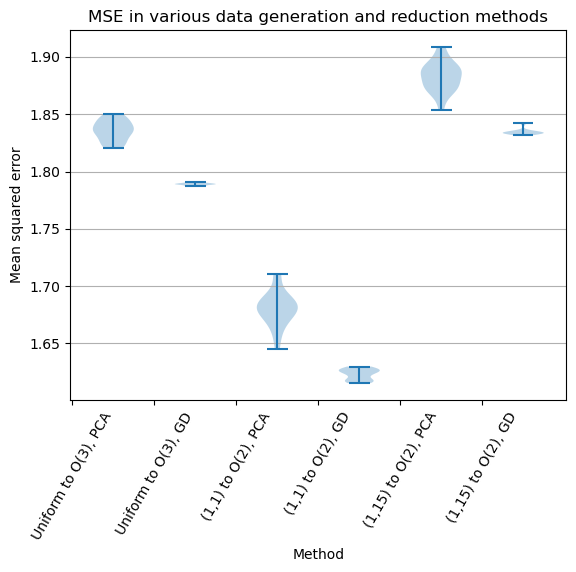

In [16]:
plt.figure(dpi=300)

fig, axes = plt.subplots()

axes.violinplot(dataset = [mmuniform_O3_results_df['PCAcost'],
                           mmuniform_O3_results_df['GDcost'],
                           mmpq_diag_results_df['PCAcost'],
                           mmpq_diag_results_df['GDcost'],
                           mmpq1_15_results_df['PCAcost'],
                           mmpq1_15_results_df['GDcost'],
                           ] )

axes.set_title('MSE in various data generation and reduction methods')
axes.yaxis.grid(True)
axes.set_xlabel('Method')
axes.set_ylabel('Mean squared error')

plt.xticks(rotation=60)
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5],
           ["Uniform to O(3), PCA", "Uniform to O(3), GD", "(1,1) to O(2), PCA", "(1,1) to O(2), GD",\
                      "(1,15) to O(2), PCA", "(1,15) to O(2), GD"],
           rotation=60
           )

plt.show()

In [17]:
# List of datasets
data = [mmuniform_O3_results_df['PCAcost'],
        mmuniform_O3_results_df['GDcost'],
        mmpq_diag_results_df['PCAcost'],
        mmpq_diag_results_df['GDcost'],
        mmpq1_15_results_df['PCAcost'],
        mmpq1_15_results_df['GDcost'],
        ]
labels = ['O3PCA', 'O3GD', '11PCA', '11GD', '115PCA','115GD']

# Perform t-tests and store results
results = []
for i in range(len(data)):
    for j in range(i + 1, len(data)):
        t_stat, p_val = stats.ttest_ind(data[i], data[j])
        results.append({
            'Selected method 1': labels[i],
            'Selected method 2': labels[j],
            't-statistic': t_stat,
            'p-value': p_val
        })

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame
print(df_results)


   Selected method 1 Selected method 2  t-statistic       p-value
0              O3PCA              O3GD    22.915007  7.557533e-24
1              O3PCA             11PCA    39.108095  2.639342e-32
2              O3PCA              11GD    92.639400  2.245417e-46
3              O3PCA            115PCA   -13.398732  5.646622e-16
4              O3PCA             115GD     0.519575  6.063735e-01
5               O3GD             11PCA    31.713196  6.019686e-29
6               O3GD              11GD   149.885101  2.708077e-54
7               O3GD            115PCA   -32.563915  2.279410e-29
8               O3GD             115GD   -70.655655  6.258763e-42
9              11PCA              11GD    16.053197  1.610802e-18
10             11PCA            115PCA   -45.356412  1.060605e-34
11             11PCA             115GD   -44.464087  2.226148e-34
12              11GD            115PCA   -84.685600  6.695752e-45
13              11GD             115GD  -170.865805  1.878101e-56
14        